In [1]:
from collections import defaultdict
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt

## Environment Encoding

We'll encode the CSV with the following states.
- 0 is on the track.
- 1 is out of bounds.
- 2 is finish line.
- 3 is starting line.

In [72]:
class Environment():
    ACTIONS = {
        0 : (1, -1),
        1 : (1, 0),
        2 : (1, 1),
        3 : (0, -1),
        4 : (0, 0),
        5 : (0, 1),
        6 : (-1, -1),
        7 : (-1, 0),
        8 : (-1, 1)
    }

    ACTION_SPACE = len(ACTIONS)

    VELOCITY_BOUND = (-10, 10)

    def __init__(self, path: str) -> None:
        self.racetrack: npt.NDArray = np.loadtxt(path, delimiter=",")
        self.starts: npt.NDArray = np.argwhere(self.racetrack == 3)
        self.ends: npt.NDArray = np.argwhere(self.racetrack == 2)
        self.reset()

    def get_actions(self):
        return [*self.ACTIONS]

    def reset(self) -> None:
        # First 2 indexes are positions, last 2 indexes are velocity.
        self.state: npt.NDArray = np.zeros(4, dtype=np.int32)
        self.state[:2]= self.starts[np.random.choice(self.starts.shape[0]), :].copy()

    def step(self, action: int, randomness: int = 0.1) -> Tuple[npt.NDArray, npt.NDArray, bool]:
        done = False
        reward = -1

        # Don't change velocity with some randomness.
        if np.random.rand() >= randomness:
            self.state[2:] += self.ACTIONS[action]

        # Constrain velocity to min and max.
        self.state[2:].clip(*self.VELOCITY_BOUND, out=self.state[2:])

        # Update state.
        self.state[:2] += self.state[2:]

        # Constrain to within racetrack array.
        self.state[:2].clip(0, np.array(self.racetrack.shape) - 1, out=self.state[:2])

        # State checks. Ignore starting state as it's only used for initialization.
        if self.racetrack[tuple(self.state[:2])] == 1:
            reward -= 10
            self.reset()
        elif self.racetrack[tuple(self.state[:2])] == 2:
            reward += 10
            done = True

        return self.state, reward, done

In [77]:
class Agent():
    def __init__(self, env: Environment, num_iterations: int = 1000, epsilon: float = 0.1, gamma: float = 0.9, alpha: float = 0.2) -> None:
        self.env: Environment = env
        self.num_iterations: int = num_iterations
        self.epsilon: float = epsilon
        self.gamma: float = gamma
        self.alpha: float = alpha

        num_velocities = abs(env.VELOCITY_BOUND[0] - env.VELOCITY_BOUND[1]) + 1
        shape = (*self.env.racetrack.shape, num_velocities, num_velocities, self.env.ACTION_SPACE)
        self.Q: npt.NDArray = np.zeros(shape)
        self.rewards: list = []
        self.policy: npt.NDArray = (1 / self.env.ACTION_SPACE) * np.ones(shape)
        self.returns: npt.NDArray = np.zeros(shape)

    def print_action(self):
        for i in range(self.env.racetrack.shape[0]):
            line = "|"
            for j in range(self.env.racetrack.shape[1]):
                action = np.argmax(self.Q[(i, j)])
                line += f"{action:02}|"
            print(f"{line}")

    def simulate_Q(self) -> None:
        episode = self.generate_episode()
        for state, action, _ in episode:
            print(f"Position: {state[1] + 1}, {state[0] + 1} | Action: {action}")

    def plot_rewards(self) -> None:
        plt.plot(range(len(self.rewards)), self.rewards)
        plt.title("On Policy - Sarsa Control")
        plt.xlabel("Episode")
        plt.ylabel("Undiscounted Return")     

    def generate_episode(self) -> list:
        episode = []
        self.env.reset()

        done = False
        while not done:
            state = self.env.state.copy()
            probabilities = self.policy[tuple(state)].copy()
            probabilities = probabilities / np.sum(probabilities)
            action = np.argmax(probabilities)
            next_state, reward, done = self.env.step(action)
            episode.append((state, action, reward))
            state = next_state
        
        return episode

    def sarsa(self) -> None:
        for i in range(self.num_iterations):
            self.env.reset()

            state = tuple(self.env.state)
            probabilities = self.policy[state].copy()
            probabilities = probabilities / np.sum(probabilities)
            action = (np.random.choice(self.env.ACTION_SPACE, p=probabilities),)

            done = False
            self.rewards.append(0)
            while not done:
                next_state, reward, done = self.env.step(*action)
                next_state = tuple(next_state)
                self.rewards[-1] += reward 

                probabilities = self.policy[next_state].copy()
                probabilities = probabilities / np.sum(probabilities)
                next_action = (np.random.choice(self.env.ACTION_SPACE, p=probabilities),)

                self.Q[state + action] += self.alpha * ((reward + self.gamma * self.Q[next_state + next_action]) - self.Q[state + action])

                optimal_action = np.argmax(self.Q[state])
                for a in self.env.get_actions():
                    if a == optimal_action:
                        self.policy[state, a] = 1 - self.epsilon + (self.epsilon / self.env.ACTION_SPACE)
                    else:
                        self.policy[state, a] = self.epsilon / self.env.ACTION_SPACE

                state = next_state
                action = next_action
            
            print(i, self.rewards[-1])

0 -14119
1 -3298
2 -781
3 -5605
4 -4856
5 -1841
6 -3609
7 -2831
8 -1479
9 -3136
10 -4882
11 -522
12 -1462
13 -1888
14 -1353
15 -3129
16 -6127
17 -1781
18 -5550
19 -2360
20 -2318
21 -2814
22 -11514
23 -4446
24 -412
25 -5919
26 -3656
27 -7468
28 -8642
29 -1365
30 -3860
31 -1661
32 -4523
33 -1929
34 -275
35 -3643
36 -8960
37 -2116
38 -266
39 -9055
40 -7044
41 -3080
42 -4366
43 -3860
44 -6694
45 -6043
46 -13389
47 -4780
48 -3708
49 -562
50 -4191
51 -2463
52 -1067
53 -11348
54 -3399
55 -181
56 -2239
57 -6776
58 -4058
59 -3600
60 -3435
61 -417
62 -3613
63 -4154
64 -7357
65 -2
66 -1149
67 -9236
68 -9964
69 -6124
70 -3126
71 -18913
72 -9649
73 -8459
74 -1828
75 -4751
76 -2695
77 -654
78 -1666
79 -1646
80 -2003
81 -8968
82 -4031
83 -9410
84 -3763
85 -445
86 -831
87 -305
88 -16249
89 -117
90 -3567
91 -6390
92 -510
93 -4568
94 -1480
95 -462
96 -714
97 -2732
98 -1120
99 -1653
100 -372
101 -93
102 -2914
103 -1603
104 -1179
105 -8574
106 -9322
107 -11529
108 -23506
109 -2409
110 -18280
111 -2254
112

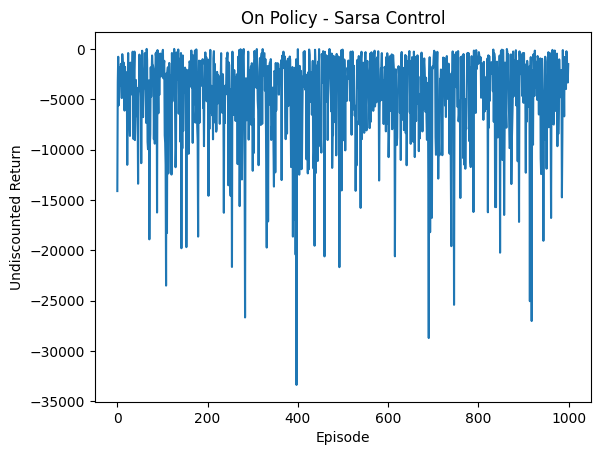

In [79]:
env = Environment("./racetrack2.csv")
agent = Agent(env)
agent.sarsa()
agent.print_action()
agent.plot_rewards()